<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Dataset Exercises</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/%s/Brain2022/" % os.environ['USERNAME']

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

# this path should point to the location of the dataset on your platform
#cache_dir = r"/Volumes/programs/mindscope/workgroups/np-behavior/vbn_data_release/vbn_s3_cache"
# cache_dir = '/home/praveen/data/vb_np_cache/'
cache_dir = '\\allen\programs\mindscope\workgroups\np-behavior\vbn_data_release\vbn_s3_cache'

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=cache_dir)

/home/praveen/.anaconda3/envs/allensdk_38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-block alert-success">

## Exercise 0: Playing with the trials table

In this exercise, we'll run a few easy analyses on the trials table

1. Creating a new column for trial "type" (hit, miss, false alarm, etc.) and plotting the number trials of each type
1. ???
1. ???

</div>

In [4]:
# Setup: first, let's get the relevant data
session_id = 1065437523
session = cache.get_ecephys_session(ecephys_session_id=session_id)

trials = session.trials

/home/praveen/.anaconda3/envs/allensdk_38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div class="alert alert-block alert-success">

### 0.1  Creating a new trial_type column and plotting the number of trials of each type

The different trial types are: hit, miss, false_alarm, correct_reject, aborted, auto_rewarded

</div>

In [5]:
# Create a new column called trial_type and assign appropriately
trials['trial_type'] = np.nan

col_names = ['hit', 'miss', 'false_alarm', 'correct_reject', 'aborted', 'auto_rewarded']
for col in col_names:
    trials.loc[trials[col] == True, 'trial_type'] = col

# A more direct way to do this is to use the function idxmax: this function finds the row- or column-index
# at which the maximum of a sequence of values occurs.
# Below, we have chosen only the columns we want, and we pass axis=1 to idxmax, to take the maximum over
# columns (axis=0 would find the row-index having the maximum value for each column)
# Also note that when taking the "maximum" over boolean values, True is interpreted as 1 and False as 0,
# hence the index of the maximum occurs wherever a True is found.

# trials['trial_type'] = trials[col_names].idxmax(axis=1)

# Examine the trials table to see how that worked
trials

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,...,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,trial_type
trials_id,,,,,,,,,,,,,,,,,,,,,
0,28.08763,29.05453,im036_r,im036_r,False,NaN,False,False,"[28.55387, 28.73684, 29.30404]",NaN,...,0.000,False,False,False,False,True,False,NaN,0.96690,aborted
1,29.58829,36.86108,im036_r,im078_r,True,32.59106,False,False,"[33.04048, 33.20773, 33.30745, 33.3908, 33.507...",33.04048,...,0.005,False,False,False,False,False,True,330.0,7.27279,auto_rewarded
2,37.09446,40.78107,im078_r,im078_r,False,NaN,False,False,[40.48052],NaN,...,0.000,False,False,False,False,True,False,NaN,3.68661,aborted
3,40.84754,50.37230,im078_r,im111_r,True,46.10256,False,False,"[46.73531, 46.83539, 46.95218, 47.06898, 47.20...",46.73531,...,0.005,False,False,False,False,False,True,1140.0,9.52476,auto_rewarded
4,50.60569,51.75679,im111_r,im111_r,False,NaN,False,False,[51.43985],NaN,...,0.000,False,False,False,False,True,False,NaN,1.15110,aborted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,3587.14531,3596.66987,im012_r,im012_r,False,3592.39945,False,True,[],NaN,...,0.000,False,False,False,True,False,False,213736.0,9.52456,correct_reject
563,3596.90314,3604.17610,im012_r,im111_r,True,3599.90621,True,False,[],NaN,...,0.000,False,False,True,False,False,False,214186.0,7.27296,miss
564,3604.40941,3612.43338,im111_r,im047_r,True,3608.16308,True,False,[],NaN,...,0.000,False,False,True,False,False,False,214681.0,8.02397,miss


<AxesSubplot:xlabel='trial_type_counts', ylabel='trial_type'>

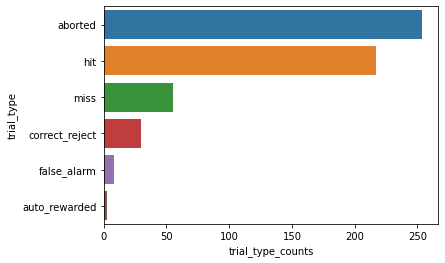

In [6]:
# Now, get the number of rows having each of these trial types using value_counts
trial_type_counts = trials['trial_type'].value_counts().rename('trial_type_counts')

# Set the index up as a separate column, for plotting purposes
trial_type_counts = trial_type_counts.reset_index().rename(columns={'index': 'trial_type'})

# Finally, plot these values using a seaborn bar plot
sns.barplot(data=trial_type_counts, x='trial_type_counts', y='trial_type')

<div class="alert alert-block alert-success">

## Exercise 1: Examining licking behavior

In this exercise, we'll examine the licking behavior of the mouse

1. Comparing lick times for hit trials and aborted trials
1. Comparing lick latency from the stimulus flash for hit trials and aborted/false alarm trials
1. Computing lick bouts

</div>

In [7]:
# Setup: first, let's get the relevant tables
session_id = 1065437523  # This is a good session for looking at lick behavior
session = cache.get_ecephys_session(ecephys_session_id=session_id)

stimulus_presentations = session.stimulus_presentations
trials = session.trials
licks = session.licks

/home/praveen/.anaconda3/envs/allensdk_38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div class="alert alert-block alert-success">

### 1.1 Comparing lick times for hit trials and aborted trials

We'll start by comparing the time between the start of the trial and the point at which the mouse licked, in aborted trials and in hit trials.

Since the mouse correctly waited until the stimulus changed in hit trials, the wait time distribution should closely match the distribution of change times. On the other hand, the distribution of lick times should be much smaller in the case of aborted trials.

</div>

In [8]:
# First, we need to find the initial lick in each trial.
# To do this, we have to identify which trial each lick falls in
trial_indices = np.searchsorted(trials['start_time'], licks['timestamps']) - 1

# Note that searchsorted gives the trial index that has a start_time *after* each lick timestamp.
# So we subtract one to get the trial index *before* the lick timestamp.

# Add the trial index to the licks table as a new column
licks['trials_id'] = trial_indices
licks.head()

,timestamps,frame,trials_id
0,28.55104,88,0
1,28.72504,99,0
2,29.30011,133,0
3,33.02635,357,1
4,33.20237,367,1


In [9]:
# Find the first lick in each trial, by grouping licks by trial index,
# and finding the smallest timestamp in each group
first_licks = licks[['timestamps', 'trials_id']].groupby('trials_id').agg('min')

# Let's also give the column a better name
first_licks.rename(columns={'timestamps': 'first_lick_time'}, inplace=True)
first_licks.head()

,first_lick_time
trials_id,
0,28.55104
1,33.02635
2,40.46992
3,46.71921
4,51.43823


In [10]:
# Now that we have the time stamp of the first lick in each trial, we can add this information to the trials table
trials_with_first_licks = pd.merge(trials, first_licks, how='left', on='trials_id')

# Compute the time from the start of the trial to the first lick
trials_with_first_licks['trial_start_to_first_lick'] = (trials_with_first_licks['first_lick_time']
                                                        - trials_with_first_licks['start_time'])
trials_with_first_licks.head()

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,...,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,first_lick_time,trial_start_to_first_lick
trials_id,,,,,,,,,,,,,,,,,,,,,
0,28.08763,29.05453,im036_r,im036_r,False,NaN,False,False,"[28.55387, 28.73684, 29.30404]",NaN,...,False,False,False,False,True,False,NaN,0.96690,28.55104,0.46341
1,29.58829,36.86108,im036_r,im078_r,True,32.59106,False,False,"[33.04048, 33.20773, 33.30745, 33.3908, 33.507...",33.04048,...,False,False,False,False,False,True,330.0,7.27279,33.02635,3.43806
2,37.09446,40.78107,im078_r,im078_r,False,NaN,False,False,[40.48052],NaN,...,False,False,False,False,True,False,NaN,3.68661,40.46992,3.37546
3,40.84754,50.37230,im078_r,im111_r,True,46.10256,False,False,"[46.73531, 46.83539, 46.95218, 47.06898, 47.20...",46.73531,...,False,False,False,False,False,True,1140.0,9.52476,46.71921,5.87167
4,50.60569,51.75679,im111_r,im111_r,False,NaN,False,False,[51.43985],NaN,...,False,False,False,False,True,False,NaN,1.15110,51.43823,0.83254


In [11]:
# Sub-select only the hit trials and the aborted trials.
hit_aborted_trials = trials_with_first_licks.query('hit == True or aborted == True').copy()
# We call .copy() after querying to prevent the SettingWithCopy warning.

# Then, make a new column indicating the trial type ('hit', or 'aborted').
# This step will be useful for plotting with seaborn
hit_aborted_trials['trial_type'] = 'hit'
hit_aborted_trials.loc[hit_aborted_trials['aborted'] == True, 'trial_type'] = 'aborted'

# Check if it worked by looking at a few random indices
hit_aborted_trials[['hit', 'aborted', 'trial_type']].loc[50:60]

,hit,aborted,trial_type
trials_id,,,
51,False,True,aborted
54,True,False,hit
55,False,True,aborted
56,True,False,hit
57,True,False,hit
59,False,True,aborted
60,True,False,hit


<AxesSubplot:xlabel='trial_start_to_first_lick', ylabel='Count'>

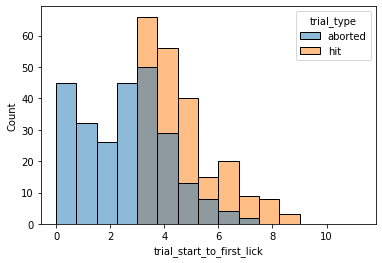

In [12]:
# Plot a histogram of the time from the start of the trial to the first lick, colored by trial type
sns.histplot(hit_aborted_trials, x='trial_start_to_first_lick', hue='trial_type', bins=np.arange(0, 12, 0.75))

<div class="alert alert-block alert-success">

### 1.2  Comparing lick latency from the stimulus flash for hit trials and aborted/false alarm trials

Next, let's compare the latency between the first lick in each trial and the preceding stimulus flash, across hit, aborted and false alarm trials.
    
For hit trials, we expect the licks to be stimulus-locked, with a response after a clear delay. If this is also true for aborted trials, it could mean that the mice are trying to use a "timing" strategy: licking after a particular number of flashes, rather than licking on the flash after the image changes.

</div>

In [13]:
# We have already added time stamps of first licks to the trials table in Exercise 1.1.

# For hit trials, we can use the change_time column from the trials table to determine the time at which
# the image changed, but for aborted trials, the change never happens, so the change_time would be NaN.

# To find the stimulus flash just before the lick for all trials, we'll need to look at the
# stimulus_presentations table, and merge it with the trials table.
stimulus_presentations['trials_id'] = np.searchsorted(trials_with_first_licks['start_time'],
                                                      stimulus_presentations['start_time']) - 1
stim_pres_with_trials = stimulus_presentations.merge(trials_with_first_licks, how='left',
                                                     on='trials_id', suffixes=('_stim', '_trial'))

# While merging, note that both the stimulus_presentations table and the trials table have
# columns of the same name, e.g., start_time.
# To distinguish these columns after merging, we use the suffixes argument.
# Default suffixes are ('_x', '_y'), but it's better to rename them to be more meaningful.

stim_pres_with_trials.columns

Index(['active', 'color', 'contrast', 'duration', 'end_frame',
       'flashes_since_change', 'image_name', 'is_change', 'omitted',
       'orientation', 'position_x', 'position_y', 'rewarded',
       'spatial_frequency', 'start_frame', 'start_time_stim', 'stimulus_block',
       'stimulus_index', 'stimulus_name', 'stop_time_stim',
       'temporal_frequency', 'trials_id', 'start_time_trial',
       'stop_time_trial', 'initial_image_name', 'change_image_name',
       'stimulus_change', 'change_time_no_display_delay', 'go', 'catch',
       'lick_times', 'response_time', 'reward_time', 'reward_volume', 'hit',
       'false_alarm', 'miss', 'correct_reject', 'aborted', 'auto_rewarded',
       'change_frame', 'trial_length', 'first_lick_time',
       'trial_start_to_first_lick'],
      dtype='object')

In [14]:
# Now that we have all the info we need, let's start by subselecting the hit, false alarm and aborted trials
stim_pres_hit_fa_aborted = stim_pres_with_trials.query('hit == True or false_alarm == True or aborted == True')

# Next, let's select the stimulus presentations that precede the lick timestamp
stim_pres_prec_first_lick = stim_pres_hit_fa_aborted.query('start_time_stim < first_lick_time').copy()
stim_pres_prec_first_lick.head()

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,first_lick_time,trial_start_to_first_lick
0,True,NaN,NaN,0.250188,75,0.0,im036_r,False,False,NaN,...,False,False,False,False,True,False,NaN,0.96690,28.55104,0.46341
12,True,NaN,NaN,0.250222,615,6.0,im078_r,False,False,NaN,...,False,False,False,False,True,False,NaN,3.68661,40.46992,3.37546
13,True,NaN,NaN,0.250222,660,7.0,im078_r,False,False,NaN,...,False,False,False,False,True,False,NaN,3.68661,40.46992,3.37546
14,True,NaN,NaN,0.250203,705,8.0,im078_r,False,False,NaN,...,False,False,False,False,True,False,NaN,3.68661,40.46992,3.37546
15,True,NaN,NaN,NaN,750,8.0,omitted,False,True,NaN,...,False,False,False,False,True,False,NaN,3.68661,40.46992,3.37546


In [15]:
# To find the stimulus presentation *just* before the lick, we can group these by trial index and select the
# stimulus presentation with the largest stimulus presentation index.

# We'll first create a new column called stim_id to contain the stimulus presentation index
temp_df = stim_pres_prec_first_lick.reset_index().rename(columns={'index': 'stim_id'})

# Then, we can perform the group-by and find the maximum stim_id in each trial
last_stim_id_in_each_trial = temp_df[['stim_id', 'trials_id']].groupby('trials_id').agg('max')

# Finally, we can choose those rows from the combined stimulus_presentation-trials-first_licks table 
# that have these stim_id's.
stim_pres_prec_first_lick = stim_pres_prec_first_lick.loc[last_stim_id_in_each_trial['stim_id']]

# Now, we can compute the latency between the first lick and the start of the preceding stimulus flash
stim_pres_prec_first_lick['lick_latency'] = (stim_pres_prec_first_lick['first_lick_time']
                                             - stim_pres_prec_first_lick['start_time_stim'])
stim_pres_prec_first_lick.head()

# Note: There's many other ways to do all this. For instance,
# 1. We could have used searchsorted to directly find the stimulus presentations preceding the
#    first lick in each trial.
# 2. Or, we could have computed the lick_latency column at the start of this cell, and then
#    grouped by trials_id to choose the rows with smallest lick latency.

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length,first_lick_time,trial_start_to_first_lick,lick_latency
0,True,NaN,NaN,0.250188,75,0.0,im036_r,False,False,NaN,...,False,False,False,True,False,NaN,0.96690,28.55104,0.46341,0.419576
16,True,NaN,NaN,0.250186,795,9.0,im078_r,False,False,NaN,...,False,False,False,True,False,NaN,3.68661,40.46992,3.37546,0.328376
31,True,NaN,NaN,0.250232,1470,7.0,im111_r,False,False,NaN,...,False,False,False,True,False,NaN,1.15110,51.43823,0.83254,0.037282
33,True,NaN,NaN,0.250193,1560,9.0,im111_r,False,False,NaN,...,False,False,False,True,False,NaN,1.51776,53.18020,1.07291,0.277977
51,True,NaN,NaN,NaN,2370,10.0,omitted,False,True,NaN,...,False,False,False,True,False,NaN,4.80412,67.10305,4.48736,0.689461


<AxesSubplot:xlabel='lick_latency', ylabel='Count'>

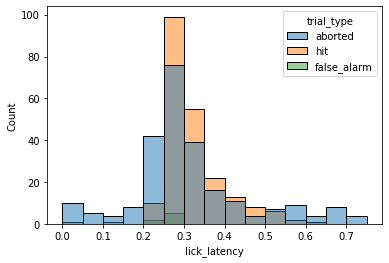

In [16]:
# Finally, let's pull out the relevant columns for plotting
lick_latencies_to_plot = stim_pres_prec_first_lick[['lick_latency', 'hit', 'false_alarm', 'aborted']].copy()

lick_latencies_to_plot['trial_type'] = 'hit'
lick_latencies_to_plot.loc[lick_latencies_to_plot['false_alarm'], 'trial_type'] = 'false_alarm'
lick_latencies_to_plot.loc[lick_latencies_to_plot['aborted'], 'trial_type'] = 'aborted'

sns.histplot(lick_latencies_to_plot, x='lick_latency', hue='trial_type', bins=np.linspace(0, 0.75, 16))

<div class="alert alert-block alert-warning">

Since both hit trials and aborted trials appear to be stimulus-locked, it would appear that this mouse is using a timing strategy.

</div>

<div class="alert alert-block alert-success">

### 1.3  Computing lick bouts

Mice tend to lick quickly in rapid succession. In this exercise, we'll examine how to separate these licks into lick "bouts".
    
</div>

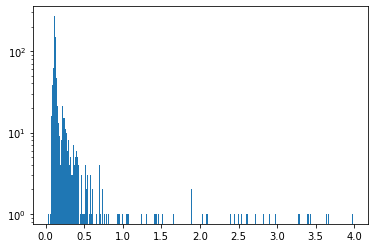

In [17]:
# Compute the inter-lick interval from the licks table
ili = np.diff(licks['timestamps'])  # Inter-lick interval

# Plot a histogram of the inter-lick interval to find a reasonable threshold for lick bouts
# Use log scaling on the y-axis to better evaluate where the lick bout cuts off
fig = plt.figure()
h = plt.hist(ili[ili < 4], bins=1000)
ax = plt.gca()
ax.set_yscale('log')

In [18]:
# Set the lick bout threshold based on where the histogram clips off (roughly)
lick_bout_threshold = 0.6

# Add the inter-lick interval to the licks table (not needed for what follows)
licks['time_from_last_lick'] = np.concatenate(([np.inf], ili))

# Create a lick-bout column in the licks table, which tells you the "bout index" that each
# lick is part of: to compute the bout index, we need to increment a counter every time the
# inter-lick interval exceeds the lick_bout_threshold that we defined above.
# np.cumsum computes a cumulative sum, and helps us do this efficiently.
licks['lick_bout'] = 0
licks.iloc[1:, licks.columns.get_indexer(['lick_bout'])] = np.cumsum((ili > lick_bout_threshold).astype(int))
licks.head()

,timestamps,frame,trials_id,time_from_last_lick,lick_bout
0,28.55104,88,0,inf,0
1,28.72504,99,0,0.17400,0
2,29.30011,133,0,0.57507,0
3,33.02635,357,1,3.72624,1
4,33.20237,367,1,0.17602,1


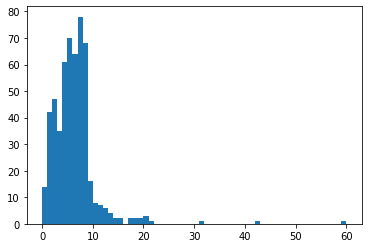

In [19]:
# Create a table with the timestamps of lick bouts, i.e., timestamps of the first lick in each bout
lick_bouts = licks[['timestamps', 'lick_bout']].groupby('lick_bout').agg('min')
inter_bout_interval = np.diff(lick_bouts['timestamps'])

# Check what the histogram of inter-bout intervals looks like
# (leaving out intervals >=1 minute in length)
plt.figure()
_ = plt.hist(inter_bout_interval[inter_bout_interval < 60], bins=np.arange(61))